,arch,hyperparams,train loss,valid loss,accuracy,time
0,FCN,{},0.659525,0.830724,0.510288,0


ResNet


KeyboardInterrupt: 

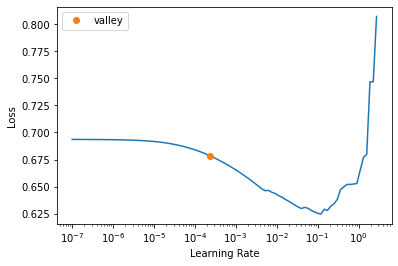

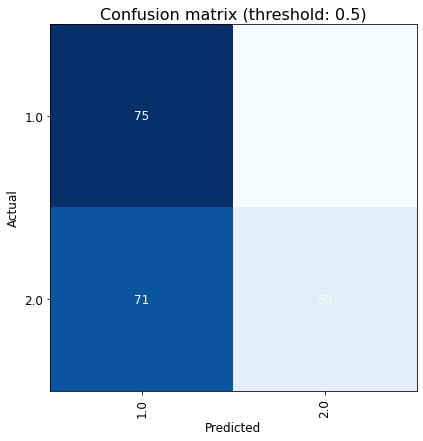

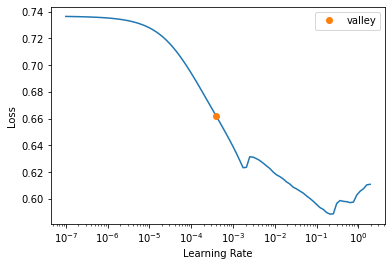

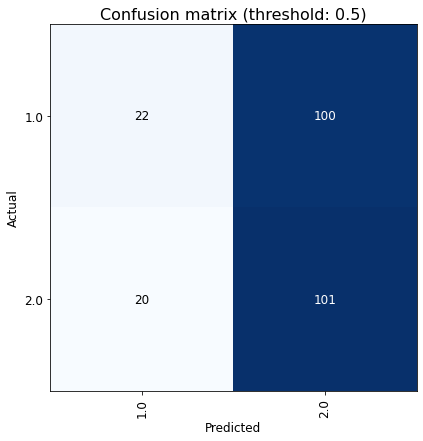

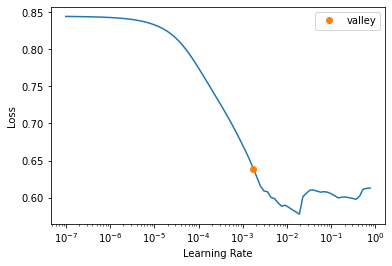

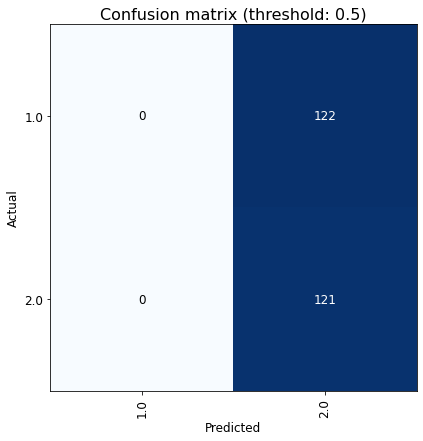

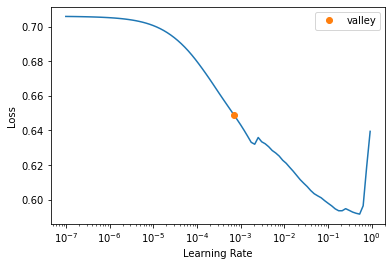

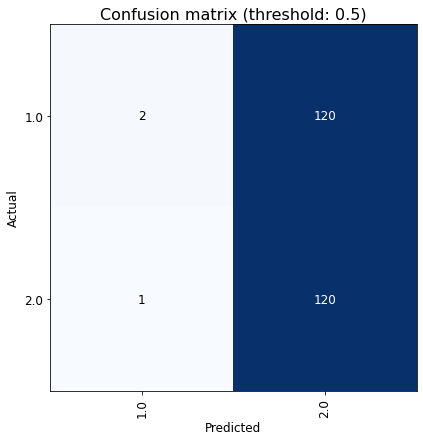

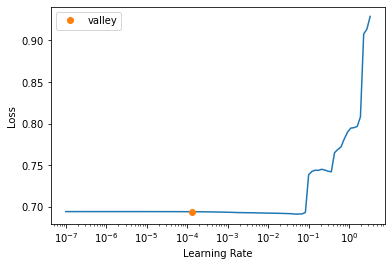

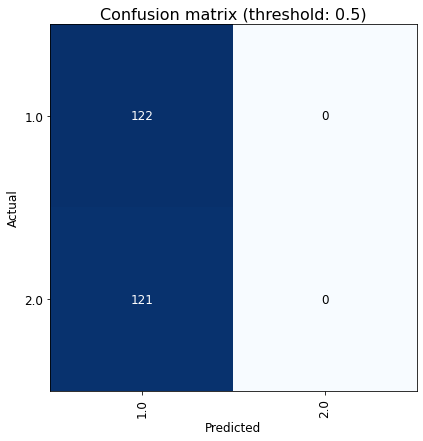

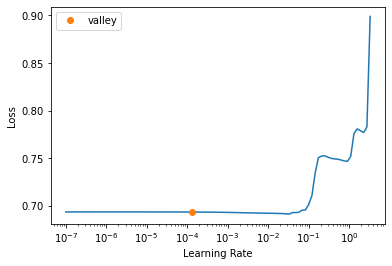

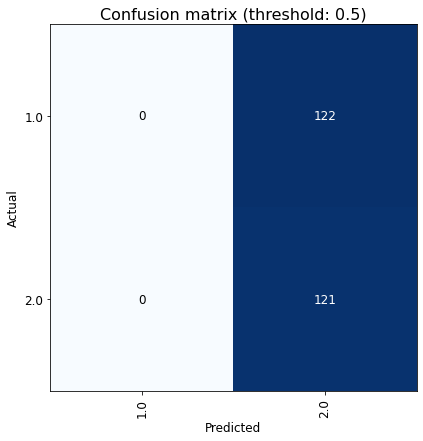

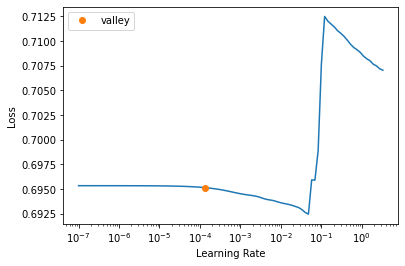

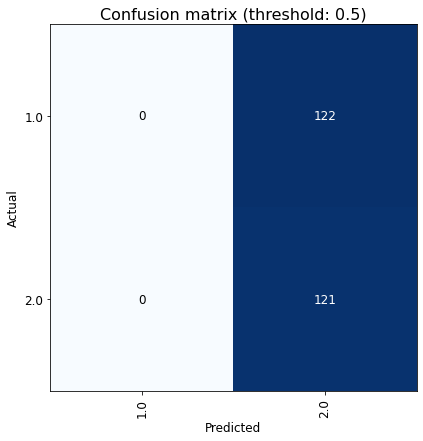

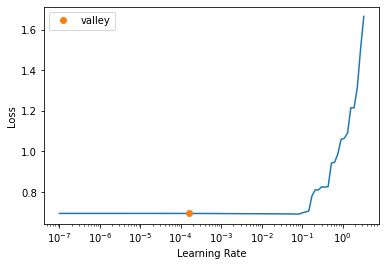

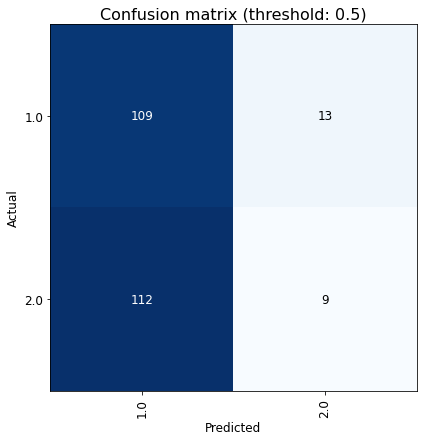

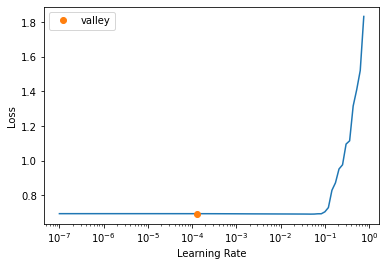

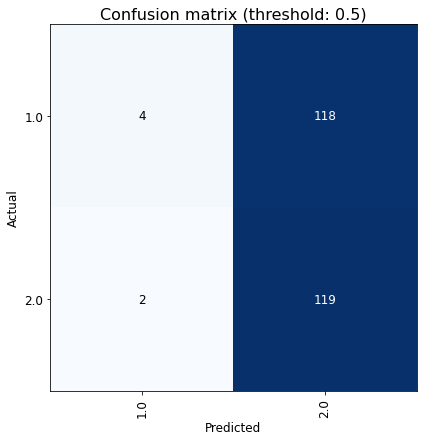

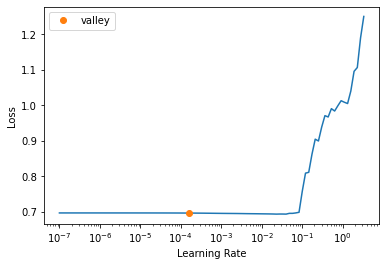

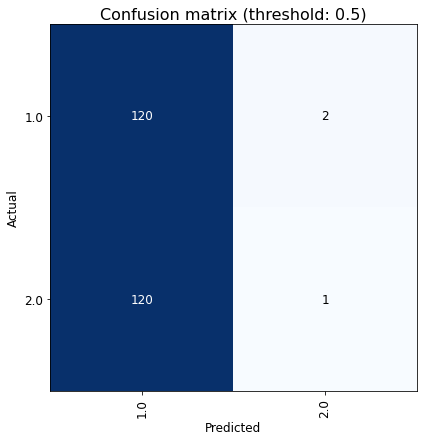

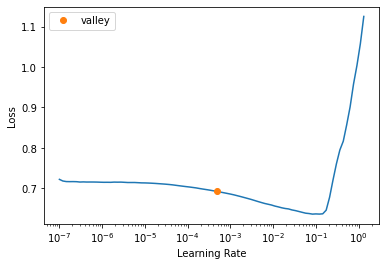

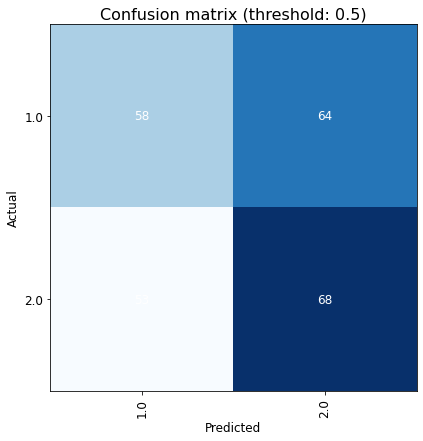

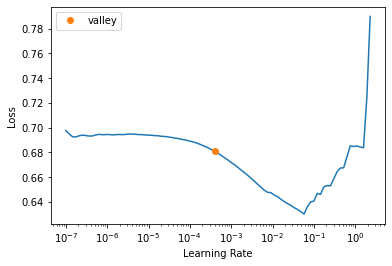

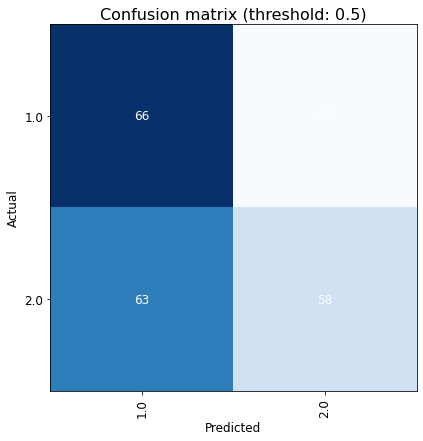

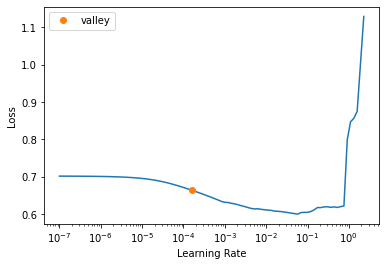

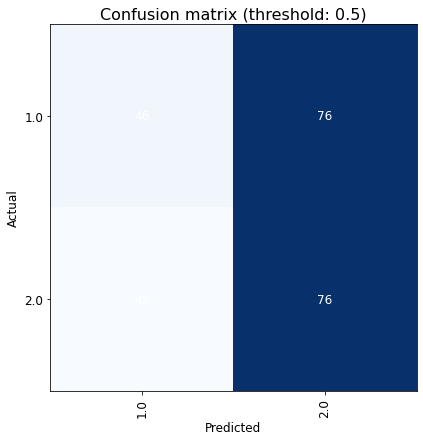

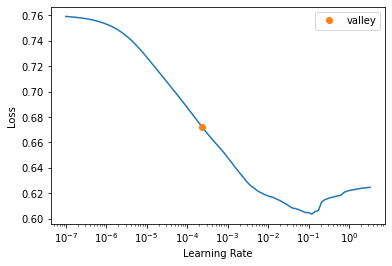

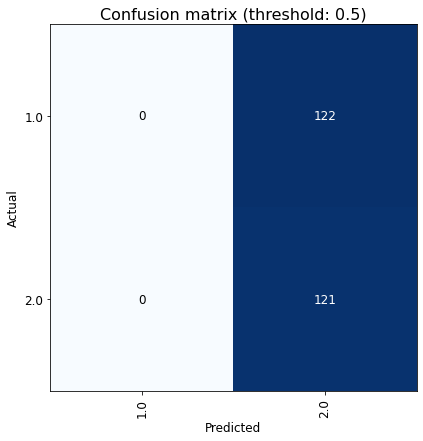

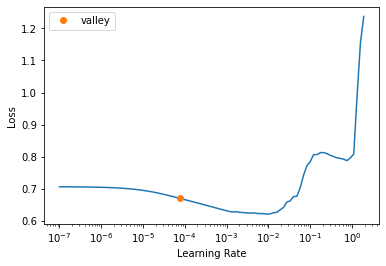

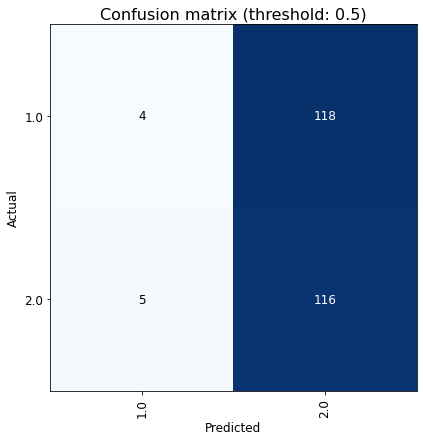

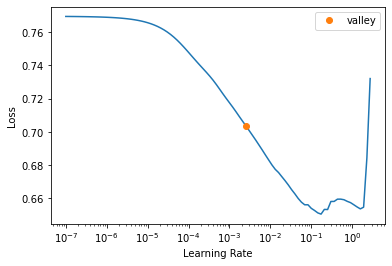

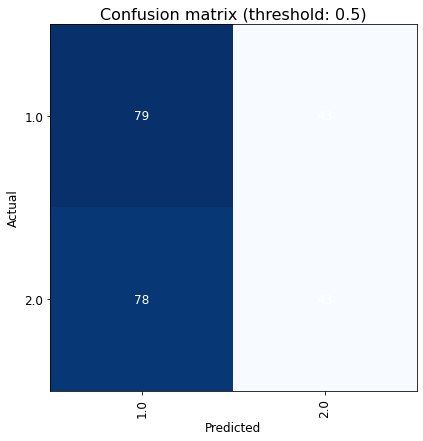

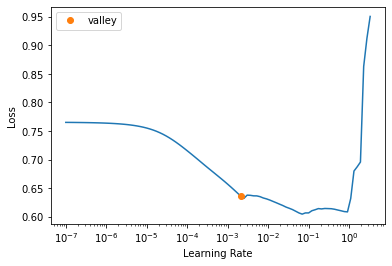

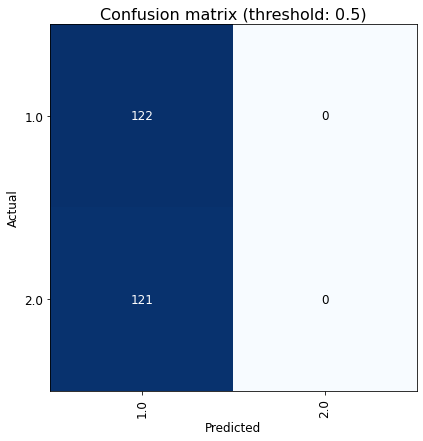

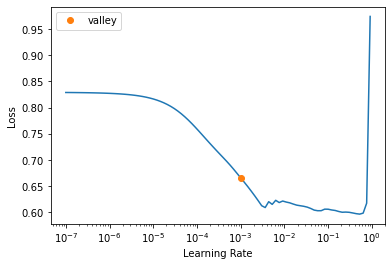

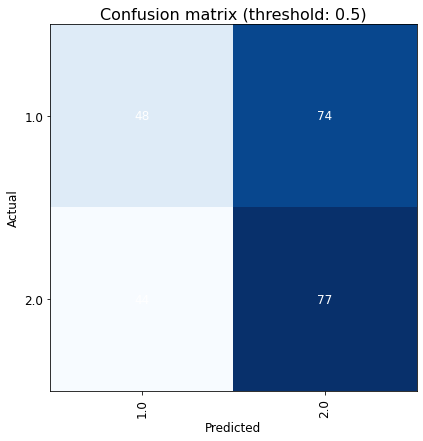

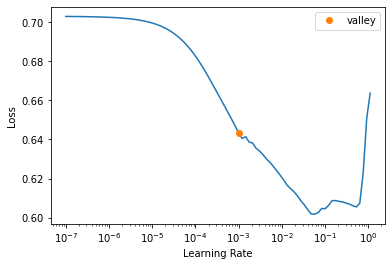

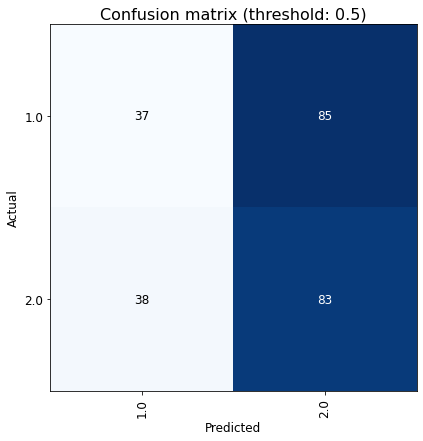

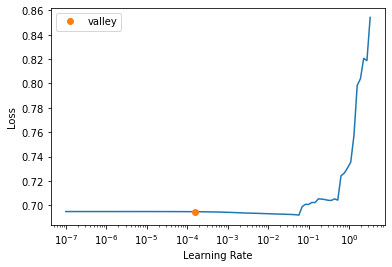

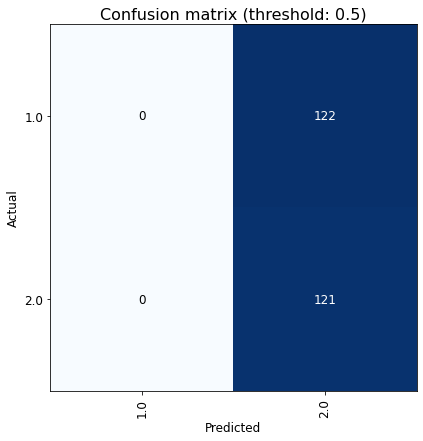

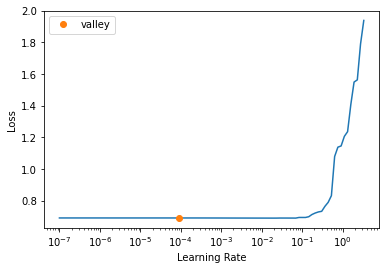

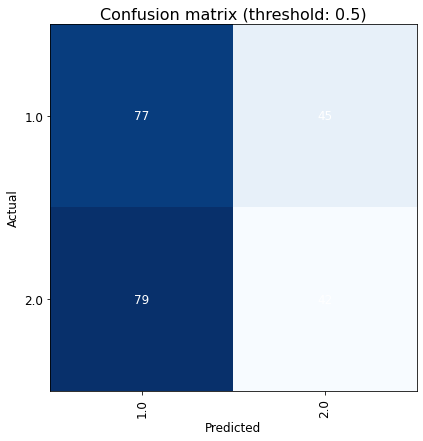

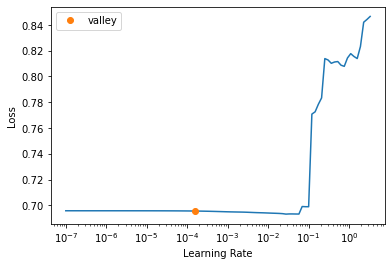

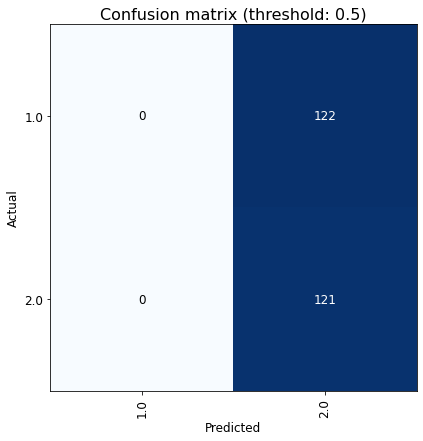

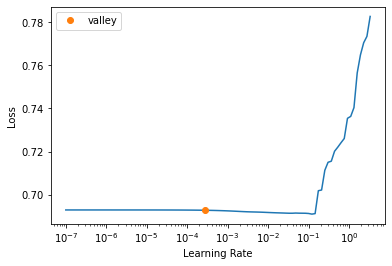

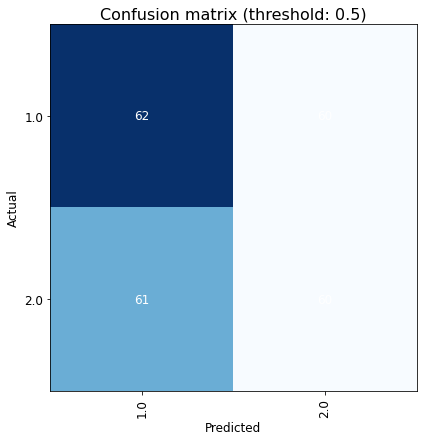

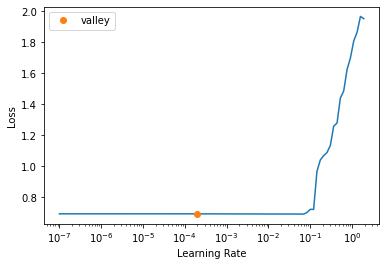

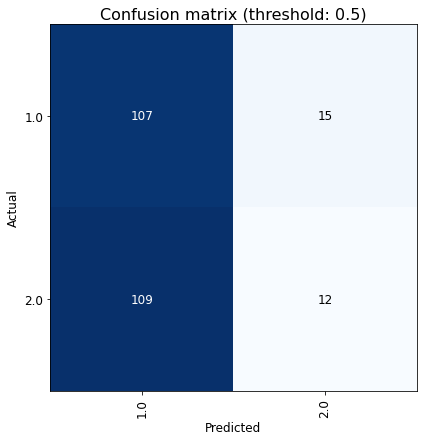

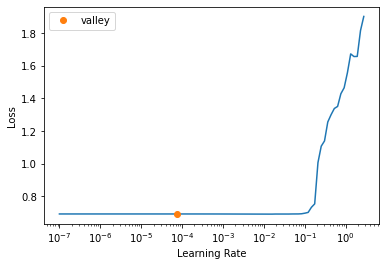

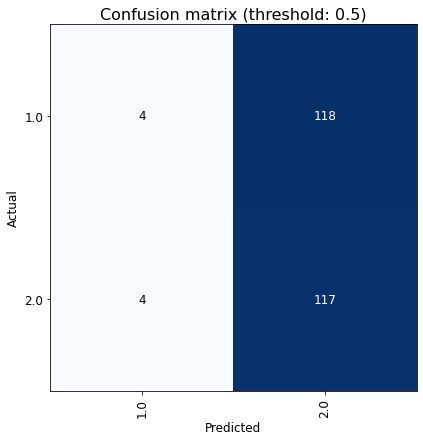

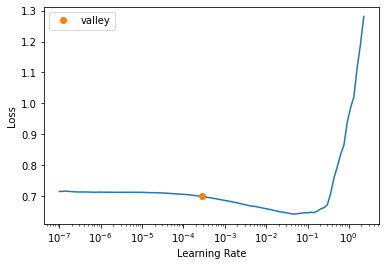

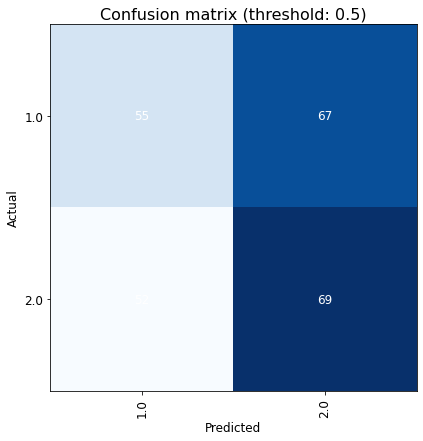

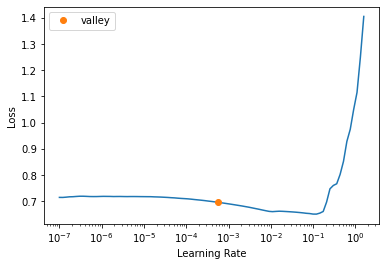

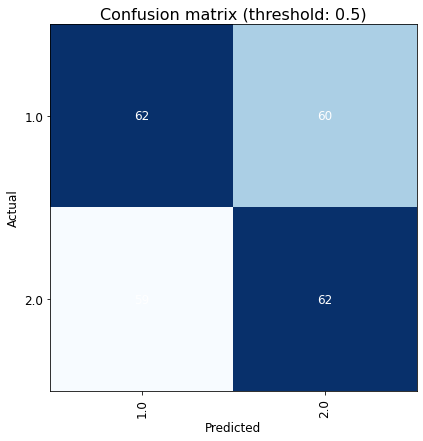

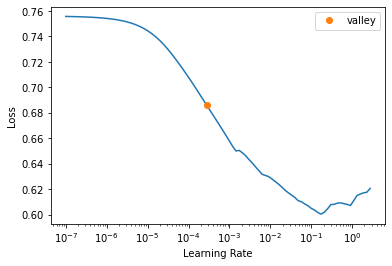

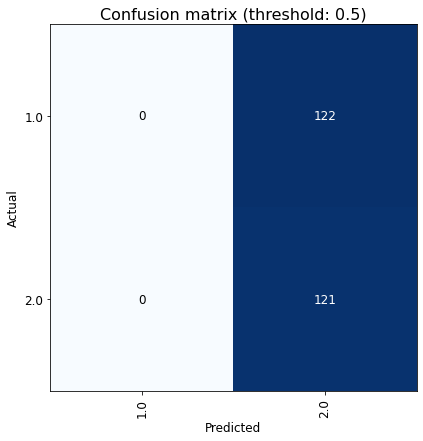

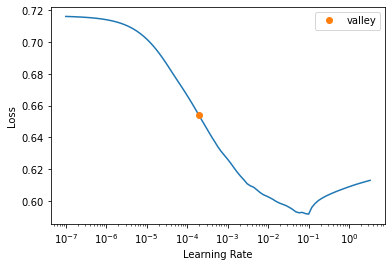

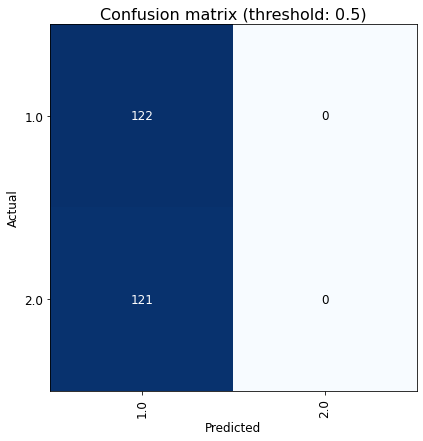

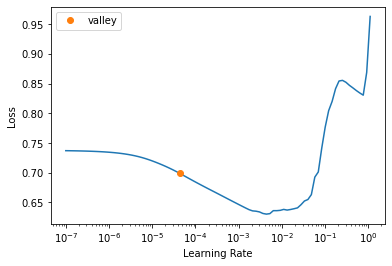

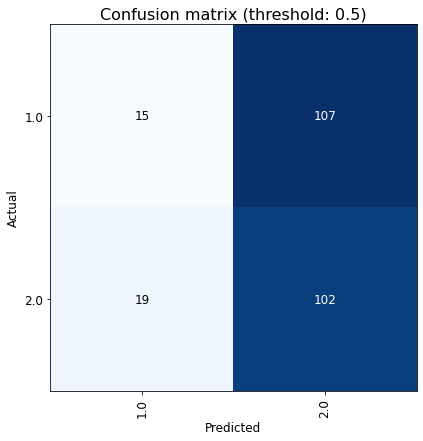

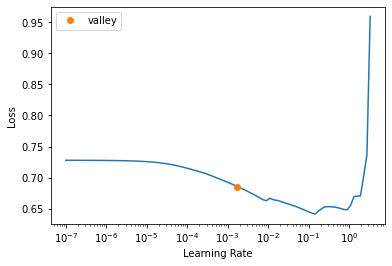

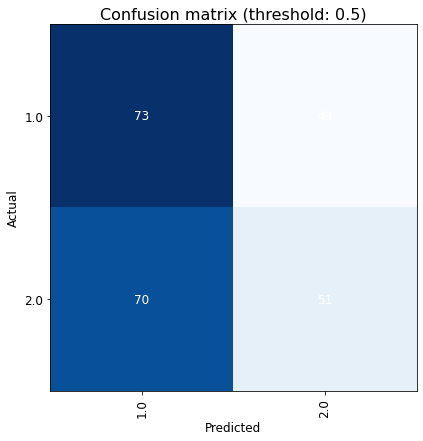

In [8]:
from tsai.all import *
import pandas as pd
from datenverarbeitung.dataloader import dataloader
from IPython.display import clear_output
import datetime
CUDA_LAUNCH_BLOCKING=1

num_scenario = 3
nr_taps = 1
learning_cycles = 10
tap_sizes = [10,20,30,40,50,60,70,80]
movers = [20,15,10,5, 0, -5, -10, -15, -20]
all_features = ["nosetip_x","nosetip_y","chin_x","chin_y","left_eye_corner_x","left_eye_corner_y","right_eye_corner_x","right_eye_corner_y","left_mouth_corner_x","left_mouth_corner_y","right_mouth_corner_x","right_mouth_corner_y","nose_end_point_x","nose_end_point_y","head_pose1_x","head_pose1_y","head_pose2_x","head_pose2_y", "pitch","roll","yaw"]
#feature_list_string = '_'.join(features_to_learn_with)
models_folder = "models/compare_univariate"
plots_folder = "vis/plots/compare_univariate"

for feature in all_features:
    print(feature)
    for tap_size in tap_sizes:
        for move_by in movers:
                dl = dataloader(scenario= num_scenario, path="/Users/adi/Nextcloud/smart_hans/AP2/Daten/headpose_opencv_pitch_roll_yaw_20220904", nr_taps=nr_taps, move_window_by=move_by, tap_size=tap_size, feature_list=[feature])
                train, test= dl.train, dl.test

                X_test, y_test = df2xy(test, target_col='target')
                X_train, y_train = df2xy(train, target_col='target')

                X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

                tfms  = [None, [Categorize()]]
                dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
                dsets

                dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
                archs = [(FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}), 
                        (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}), 
                        (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
                        (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {})]

                results = pd.DataFrame(columns=['arch', 'hyperparams',  'train loss', 'valid loss', 'accuracy', 'time'])
                for i, (arch, k) in enumerate(archs):

                        save_name = "scenario_{}_{}_feature_{}_tapsize_{}_mv_{}".format(num_scenario, arch.__name__,feature,str(tap_size),str(move_by))
                        ## set parameters for modelsaves
                        scenario_name_stage0 = save_name+"_nr_taps_{}".format(str(nr_taps))+"_stage0"

                        model = create_model(arch, dls=dls, **k)
                        print(model.__class__.__name__)
                        learn = Learner(dls, model,  metrics=accuracy)

                        learn.save(scenario_name_stage0)
                        learn.load(scenario_name_stage0)
                        learn.lr_find()
                        scenario_name_stage1 = scenario_name_stage0.replace("0","1")

                        start = time.time()
                        learn.fit_one_cycle(learning_cycles, 1e-3)
                        elapsed = time.time() - start
                        vals = learn.recorder.values[-1]
                        results.loc[i] = [arch.__name__, k, vals[0], vals[1], vals[2], int(elapsed)]
                        results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)

                        learn.plot_confusion_matrix()
                        current_time= datetime.datetime.now().strftime('%d%m%Y_%H%M%S')
                        plot_name = plots_folder+"/confusion_matrix_"+save_name+"_nrtaps_{}_features_{}_lc_{}_tapsize_{}_mv_{}_{}.png".format(str(nr_taps),feature,learning_cycles,str(tap_size),str(move_by), current_time)
                        plt.savefig(plot_name, ext='png', bbox_inches="tight")
                        clear_output(wait=True)
                        display(results)

In [1]:
tap_sizes = [10,20,30,40,50,60,70,80]
movers = [20,15,10,5, 0, -5,-10,-15,-20]
all_features = ["nosetip_x","nosetip_y","chin_x","chin_y","left_eye_corner_x","left_eye_corner_y","right_eye_corner_x","right_eye_corner_y","left_mouth_corner_x","left_mouth_corner_y","right_mouth_corner_x","right_mouth_corner_y","nose_end_point_x","nose_end_point_y","head_pose1_x","head_pose1_y","head_pose2_x","head_pose2_y", "pitch","roll","yaw"]
features_to_learn_with = []
counter = 0 
for feature in all_features:
    print(feature)
    for tap_size in tap_sizes:
        for move_by in movers:
            
            counter += 1
print(counter)

nosetip_x
nosetip_y
chin_x
chin_y
left_eye_corner_x
left_eye_corner_y
right_eye_corner_x
right_eye_corner_y
left_mouth_corner_x
left_mouth_corner_y
right_mouth_corner_x
right_mouth_corner_y
nose_end_point_x
nose_end_point_y
head_pose1_x
head_pose1_y
head_pose2_x
head_pose2_y
pitch
roll
yaw
1344
